In [1]:
import os
import pickle
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from lammps_implicit_der.systems import BccBinary, get_bcc_alloy_A_delta_B
from lammps_implicit_der import SNAP
from lammps_implicit_der.tools import error_tools, plot_tools

## Generate perturbed Ni-Mo alloy with given by the $\delta$ parameter:

For Ni atoms, $\Theta^{\mathrm{Ni}}$ is fixed. For Mo atoms the potential is setup as follows:

$$\Theta(\delta) = \delta \times \Theta^{\mathrm{Ni}} + (1-\delta) \times \Theta^{\mathrm{Mo}}$$

$$\delta = 0 \rightarrow \Theta(\delta)=\Theta^{\mathrm{Mo}}$$
$$\delta = 1 \rightarrow \Theta(\delta)=\Theta^{\mathrm{Ni}}$$

In this way, at $\delta=0$, we have the 'quasi' Mo atoms. 'Quasi' because the snapparams are taken from the Ni potential.

## True Nickel-Molybdenum random alloy

In [2]:
ncell_x = 2
specie_B_concentration=0.5

In [3]:
bcc_alloy_Ni_Mo = BccBinary(datafile=None,
                            snapcoeff_filename='NiMo.snapcoeff',
                            ncell_x=ncell_x,
                            specie_B_concentration=specie_B_concentration,
                            minimize=True)

None
Running LAMMPS with the following arguments:
-screen none -log none
Setting up SNAP potential
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 2.396e-09, force norm: 8.923e-09


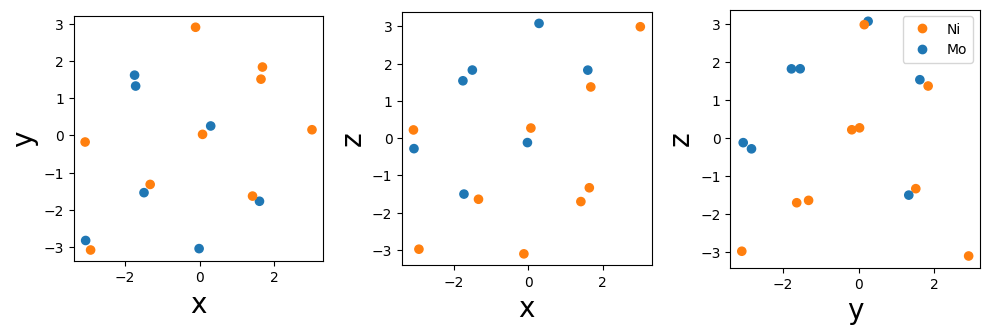

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
specie_colors = [specie_color[s] for s in bcc_alloy_Ni_Mo.species]
plot_tools.plot_coords(axes, bcc_alloy_Ni_Mo.X_coord.reshape(-1, 3), c=specie_colors, s=35)
plt.tight_layout()
plot_tools.setup_color_legend(axes[2], list(specie_color.values()), bcc_alloy_Ni_Mo.pot.elem_list)
plt.show()

## Quasi-Ni-Mo alloy

None
Running LAMMPS with the following arguments:
-screen none -log none
Setting up SNAP potential
Number of atoms: 16, largest force value: 4.183e-01, force norm: 1.321e+00
Overwriting ./Ni_delta_Mo.snapcoeff
Saved SNAP coefficients to ./Ni_delta_Mo.snapcoeff
Saved SNAP parameters to ./Ni_delta_Mo.snapparam
None
Running LAMMPS with the following arguments:
-screen none -log bcc_alloy_tmp.log
Setting up SNAP potential
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 2.396e-09, force norm: 8.923e-09


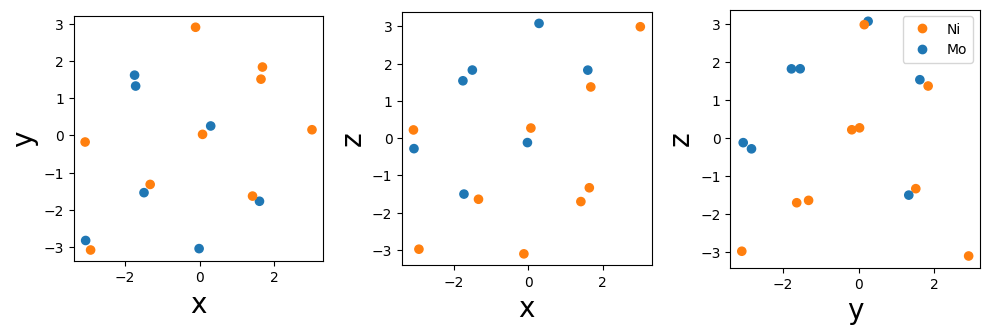

16


In [5]:
# Test the function get_bcc_alloy_A_delta_B: with delta = 0.0 we should get the same structure as above
bcc_alloy_Ni_Mo_test = get_bcc_alloy_A_delta_B(delta=0.0,
                                                ncell_x=ncell_x,
                                                minimize=True,
                                                datafile=None,
                                                specie_B_concentration=specie_B_concentration)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_alloy_Ni_Mo_test.X_coord.reshape(-1, 3), c=specie_colors, s=35)
plt.tight_layout()
plot_tools.setup_color_legend(axes[2], list(specie_color.values()), bcc_alloy_Ni_Mo_test.pot.elem_list)
plt.show()

print(bcc_alloy_Ni_Mo_test.Natom)

## Perturbed Ni-Mo with $\Theta^{\mathrm{Ni}}$, $\Theta^{\mathrm{Mo}}(\delta)$

In [6]:
# Perturb slightly the parameters
delta = 0.4
bcc_alloy_Ni_Mo_pert = get_bcc_alloy_A_delta_B(delta=delta,
                                                ncell_x=ncell_x,
                                                minimize=True,
                                                datafile=None,
                                                specie_B_concentration=specie_B_concentration)



None
Running LAMMPS with the following arguments:
-screen none -log none
Setting up SNAP potential
Number of atoms: 16, largest force value: 4.183e-01, force norm: 1.321e+00
Overwriting ./Ni_delta_Mo.snapcoeff
Saved SNAP coefficients to ./Ni_delta_Mo.snapcoeff
Saved SNAP parameters to ./Ni_delta_Mo.snapparam
None
Running LAMMPS with the following arguments:
-screen none -log bcc_alloy_tmp.log
Setting up SNAP potential
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 3.219e-09, force norm: 9.167e-09


In [7]:
# Compute the implicit derivative with respect to Mo parameters
method = 'inverse'
#method='energy'
dX_dTheta = bcc_alloy_Ni_Mo.implicit_derivative(method=method)

100%|██████████| 48/48 [00:00<00:00, 307.18it/s]


In [8]:
Theta_Mo_pert = bcc_alloy_Ni_Mo_pert.pot.Theta_dict['Mo']['Theta'].copy()
Theta_Mo = bcc_alloy_Ni_Mo.pot.Theta_dict['Mo']['Theta'].copy()

dTheta = Theta_Mo_pert - Theta_Mo

In [9]:
# Predicted coordinate perturbation
dX_pred = dTheta @ dX_dTheta

X_pred = bcc_alloy_Ni_Mo.minimum_image(bcc_alloy_Ni_Mo.X_coord + dX_pred)

In [10]:
# True change
X_true = bcc_alloy_Ni_Mo_pert.X_coord.copy()
dX_true = bcc_alloy_Ni_Mo.minimum_image(X_true - bcc_alloy_Ni_Mo.X_coord)

In [11]:
output_dict = {
    'ncell_x': ncell_x,
    'Natom': bcc_alloy_Ni_Mo.Natom,
    'delta': delta,
    'dTheta': dTheta,
    'method': method,
    'dX_dTheta': dX_dTheta,
    'Theta_Ni': bcc_alloy_Ni_Mo.pot.Theta_dict['Ni']['Theta'].copy(),
    'Theta_Mo': bcc_alloy_Ni_Mo.pot.Theta_dict['Mo']['Theta'].copy(),
    'Theta_Mo_pert': Theta_Mo_pert,
    'dX_dTheta': dX_dTheta,
    'dX_pred': dX_pred,
    'dX_true': dX_true,
    'X_pred': X_pred,
    'X_true': X_true,
    'X0': bcc_alloy_Ni_Mo.X_coord.copy(),
    'species': bcc_alloy_Ni_Mo.species.copy(),
}

# Save to pickle
output_filename = f'HEA_NiMo_{method}_{delta:.2f}_{ncell_x:03d}.pkl'
with open(output_filename, 'wb') as f:
    pickle.dump(output_dict, f)

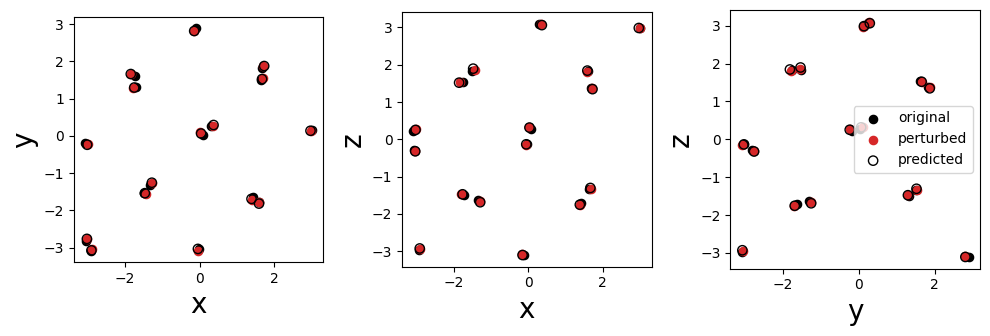

In [12]:
# Plot the coordinates
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
specie_colors = [specie_color[s] for s in bcc_alloy_Ni_Mo.species]

color_list = ['black','tab:orange', 'tab:blue', 'black']
label_list = ['original', 'Ni', '$\delta$Mo', 'from dX/dTheta']

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

plot_tools.plot_coords(axes, bcc_alloy_Ni_Mo.X_coord.reshape(-1, 3), c='black', s=35, label='original')
plot_tools.plot_coords(axes, X_true.reshape(-1, 3), c='tab:red', s=35, label='perturbed')
plot_tools.plot_coords(axes, X_pred.reshape(-1, 3), s=45, label='predicted', facecolors='none', edgecolors='black', marker='o')
plt.tight_layout()
plt.show()

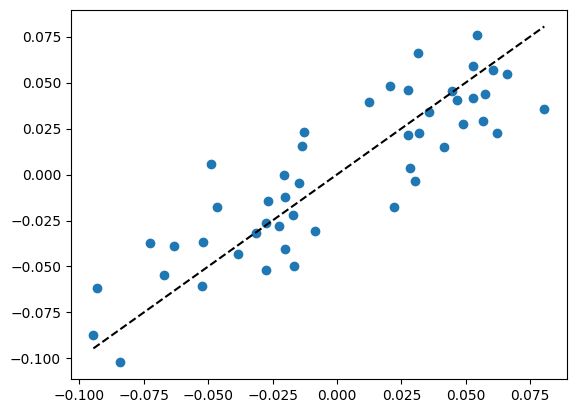

In [15]:
plt.plot(dX_true, dX_pred, 'o')
plt.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], 'k--')

Text(0.5, 0, 'dX')

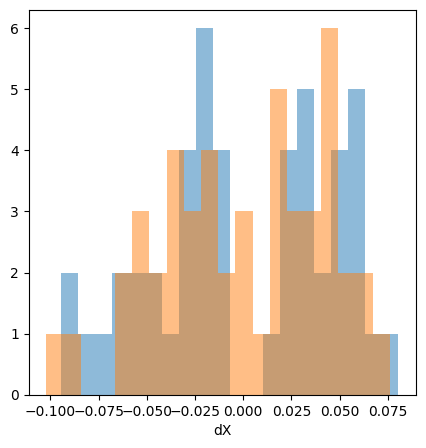

In [14]:
# plot histogram dX_pred vs dX_true
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(dX_true, bins=20, color='tab:blue', alpha=0.5, label='true')
ax.hist(dX_pred, bins=20, color='tab:orange', alpha=0.5, label='predicted')
ax.set_xlabel('dX')
